In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import os
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import Dataset
from PIL import Image

In [6]:
# Set image dimensions
IMG_SIZE = 256
NUM_CLASSES = 21
BATCH_SIZE = 32

In [7]:
# Data Preprocessing and Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255)
])

In [8]:
# Load and process .tif images manually
def load_tif_images(directory):
    images, labels = [], []
    class_names = sorted(os.listdir(directory))

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        for img_file in os.listdir(class_path):
            if img_file.endswith(".tif"):
                img_path = os.path.join(class_path, img_file)
                img = Image.open(img_path).convert('RGB')
                img = img.resize((IMG_SIZE, IMG_SIZE))
                images.append(np.array(img))
                labels.append(label)

    images = np.array(images) / 255.0
    labels = np.array(labels)
    return images, labels, class_names

In [ ]:
import os

def count_images_in_directory(directory_path):
    """
    Counts the number of images in a given directory and its subdirectories.
    
    Parameters:
        directory_path (str): Path to the directory containing image folders.
        
    Returns:
        int: Total number of images in the directory.
    """
    image_count = 0
    for class_name in os.listdir(directory_path):
        class_dir = os.path.join(directory_path, class_name)
        if os.path.isdir(class_dir):
            # Count images with supported extensions
            image_count += len([img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.jpeg', '.png', '.bmp','.tif'))])
    return image_count

# Paths to train and test directories
train_dir = '/Users/karn/Documents/Land-Use-Classification/train'  # Replace with actual train path

# Count images
train_image_count = count_images_in_directory(train_dir)
print(f"Number of images in train directory: {train_image_count}")

# If test directory exists, count test images
if os.path.exists(test_dir):
    test_image_count = count_images_in_directory(test_dir)
    print(f"Number of images in val directory: {test_image_count}")
else:
    print("Test directory does not exist.")


In [ ]:
import os
import random
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuration
ORIGINAL_DIR = '/Users/karn/Documents/Land-Use-Classification/train'  # Contains 21 class folders with 80 images each
BASE_DIR = '/Users/karn/Documents/Land-Use-Classification/data'  # Will contain train/test/val splits
AUGMENT_FACTOR = 1.5  # Generate 5x augmented data for training

# Create base directories
os.makedirs(BASE_DIR, exist_ok=True)
train_dir = os.path.join(BASE_DIR, 'train')
test_dir = os.path.join(BASE_DIR, 'test')
val_dir = os.path.join(BASE_DIR, 'val')

# Split ratios (70-15-15)
split_ratios = {'train': 0.7, 'test': 0.15, 'val': 0.15}

# Create split directories
for split in ['train', 'test', 'val']:
    for class_name in os.listdir(ORIGINAL_DIR):
        os.makedirs(os.path.join(BASE_DIR, split, class_name), exist_ok=True)

# Split and copy files
for class_name in os.listdir(ORIGINAL_DIR):
    class_path = os.path.join(ORIGINAL_DIR, class_name)
    if not os.path.isdir(class_path): continue
    
    images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)
    
    n = len(images)
    train_end = int(n * split_ratios['train'])
    test_end = train_end + int(n * split_ratios['test'])
    
    for i, img in enumerate(images):
        src = os.path.join(class_path, img)
        if i < train_end:
            dest_dir = train_dir
        elif i < test_end:
            dest_dir = test_dir
        else:
            dest_dir = val_dir
            
        copyfile(src, os.path.join(dest_dir, class_name, img))

print("Dataset splitting completed!")

# Verify counts
print(f"Original images per class: {len(images)}")
print(f"Train images per class: {len(os.listdir(os.path.join(train_dir, class_name)))}")
print(f"Test images per class: {len(os.listdir(os.path.join(test_dir, class_name)))}")
print(f"Val images per class: {len(os.listdir(os.path.join(val_dir, class_name)))}")


In [ ]:
# Configure augmentation (matches paper parameters)
aug_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply augmentation to training set
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path): continue
    
    # Get original image count
    orig_images = [img for img in os.listdir(class_path) if not img.startswith('aug_')]
    
    # Augment each original image
    for img_name in orig_images:
        img_path = os.path.join(class_path, img_name)
        
        # Load and reshape image
        img = tf.keras.preprocessing.image.load_img(img_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)
        
        # Generate augmented copies
        i = 0
        for batch in aug_datagen.flow(img_array, 
                                    batch_size=1,
                                    save_to_dir=class_path,
                                    save_prefix='aug',
                                    save_format='jpg'):
            i += 1
            if i >= AUGMENT_FACTOR - 1:  # Preserve original + 4 augmented copies
                break

print(f"Augmentation completed! New train size: {len(os.listdir(class_path))} images/class")


In [ ]:
print(f"Train images per class: {len(os.listdir(os.path.join(train_dir, class_name)))}")
print(f"Test images per class: {len(os.listdir(os.path.join(test_dir, class_name)))}")
print(f"Val images per class: {len(os.listdir(os.path.join(val_dir, class_name)))}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

# Set parameters
IMAGE_SIZE = (256, 256)  # Matches paper's input size
BATCH_SIZE = 32
NUM_CLASSES = 21
EPOCHS = 100  # As per paper's training duration

# Configure data generators with paper-specific preprocessing
train_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    '/Users/karn/Documents/Land-Use-Classification/data/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    '/Users/karn/Documents/Land-Use-Classification/data/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define a simple lightweight CNN model
def build_lightweight_cnn(input_shape=(256, 256, 3), num_classes=21):
    model = models.Sequential([
        # Convolutional Layer 1 + MaxPooling
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Layer 2 + MaxPooling
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Layer 3 + MaxPooling
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flattening the output and adding Dense Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Dropout for regularization
        layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation
    ])
    return model

In [ ]:
# Callbacks from paper's methodology
checkpoint = ModelCheckpoint('main1_model.h5', 
                            monitor='val_accuracy',
                            save_best_only=True,
                            mode='max')

early_stop = EarlyStopping(monitor='val_loss',
                          patience=15,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.2,
                             patience=5,
                             min_lr=1e-6)

In [ ]:
# Build and compile the lightweight CNN model
model = build_lightweight_cnn(input_shape=(256, 256, 3), num_classes=NUM_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary to check size and structure
model.summary()

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Model Summary:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_108 (Conv2D)             │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 21)             │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,247 (1.53 MB)

 Trainable params: 400,245 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Found 252 images belonging to 21 classes.


/opt/homebrew/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step

Model Evaluation Metrics:
Accuracy: 0.8968
Precision: 0.9083
Recall: 0.8968
F1 Score: 0.8965

Classification Report:
                    precision    recall  f1-score   support

     agricultural       0.80      1.00      0.89        12
         airplane       0.92      0.92      0.92        12
  baseballdiamond       1.00      0.83      0.91        12
            beach       1.00      0.83      0.91        12
        buildings       1.00      0.83      0.91        12
        chaparral       1.00      1.00      1.00        12
 denseresidential       0.75      1.00      0.86        12
           forest       1.00      1.00      1.00        12
          freeway       0.85      0.92      0.88        12
       golfcourse       0.85      0.92      0.88        12
           harbor       1.00      1.00      1.00        12
     intersection       0.92      0.92      0.92        12
mediumresidential       0.88      0.58      0.70        12
   mobilehomepa

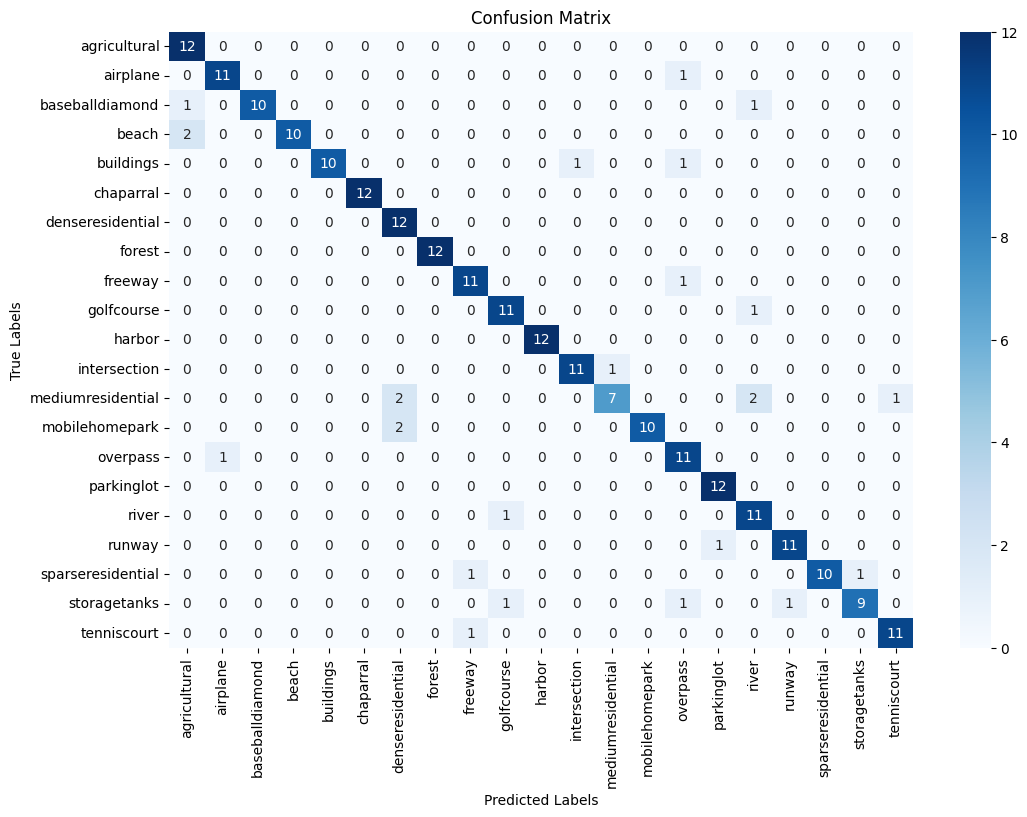

In [10]:
# Set paths and parameters
test_data_dir = "/Users/karn/Documents/Land-Use-Classification/data/val"  # Replace with the path to your test dataset
image_size = (256, 256)
batch_size = 32

# Load the trained model
model = load_model("/Users/karn/Documents/Land-Use-Classification/best_lightweight_cnn_model.h5")  # Replace with your saved model file name

# Print the model summary
print("\nModel Summary:")
model.summary()

# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Keep order for confusion matrix
)

# Get true labels and class names
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Get predictions from the model
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average="weighted")
recall = recall_score(true_labels, pred_labels, average="weighted")
f1 = f1_score(true_labels, pred_labels, average="weighted")

# Print evaluation metrics
print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate and print classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("\nClassification Report:\n", report)

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
